In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [24]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

In [25]:
def extract_age_label(filename):
    return int(filename.split("_")[0])

In [26]:
image_filenames = [f for f in os.listdir(path) if f.endswith(".jpg")]
ages = np.array([extract_age_label(f) for f in image_filenames])


In [27]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 53582 images belonging to 3 classes.
Found 13394 images belonging to 3 classes.


In [28]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [29]:
gx = base_model.output
gx = GlobalAveragePooling2D()(gx)
gx = Dense(512, activation='relu')(gx)
gx = Dropout(0.5)(gx)
gx = Dense(1, activation='linear')(gx)

In [30]:
model = Model(inputs=base_model.input, outputs=gx)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

In [31]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 194s 110ms/step - loss: 0.9830 - mae: 0.8868 - val_loss: 0.8345 - val_mae: 0.8547
Epoch 2/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 182s 109ms/step - loss: 0.8562 - mae: 0.8587 - val_loss: 0.8355 - val_mae: 0.8550
Epoch 3/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 182s 108ms/step - loss: 0.8543 - mae: 0.8577 - val_loss: 0.8358 - val_mae: 0.8553
Epoch 4/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 175s 105ms/step - loss: 0.8570 - mae: 0.8602 - val_loss: 0.8471 - val_mae: 0.8556
Epoch 5/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 175s 105ms/step - loss: 0.8534 - mae: 0.8573 - val_loss: 0.8381 - val_mae: 0.8560
Epoch 6/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 175s 105ms/step - loss: 0.8523 - mae: 0.8572 - val_loss: 0.8397 - val_mae: 0.8563
Epoch 7/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 182s 109ms/step - loss: 0.8522 - mae: 0.8567 - val_loss: 0.8406 - val_mae: 0.8565
Epoch 8/20
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 175s 104ms/step - loss: 0.8502 - mae: 0.8566 - val_loss: 0.8362 - val_mae: 0.8566
Epoch 9/

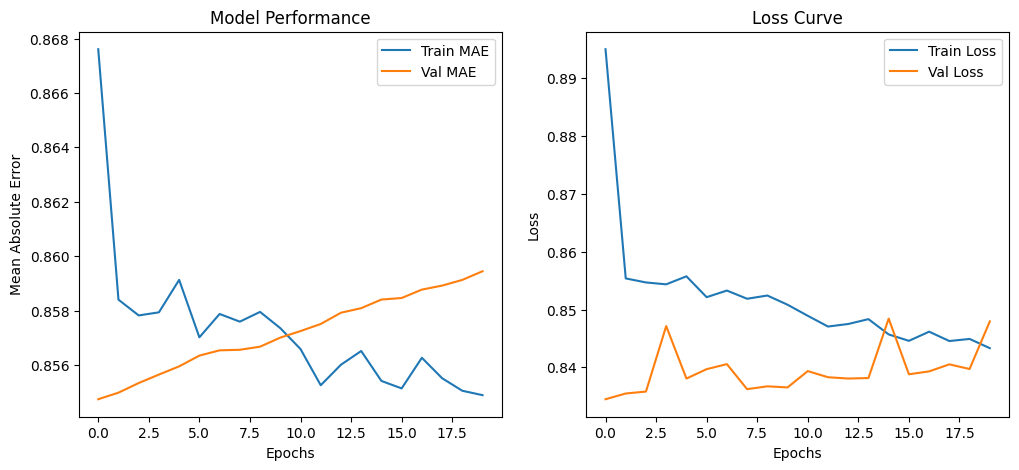

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Model Performance')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

In [33]:
model.save("age_detection_model.h5")